# Information Extraction for Social Science Research

### ICWSM 2022 Tutorial Series

### June 6, 2022

### Andy Halterman (NYU Data Science)

This tutorial will introduce you to *information extraction* for social science: techniques for turning documents into structured data by extracting specific words, phrases, or pieces of information from within documents.

Rather than alternating between slides and code, we'll use a single Colab notebook for everything.

----

Let's get started by installing `spaCy`, a library for doing natural language processing, and download some other data we'll need for the tutorial.

In [ ]:
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2020 NVIDIA Corporation
Built on Mon_Oct_12_20:09:46_PDT_2020
Cuda compilation tools, release 11.1, V11.1.105
Build cuda_11.1.TC455_06.29190527_0


In [ ]:
!pip install --upgrade spacy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 6.2 MB 4.9 MB/s 
     |████████████████████████████████| 660 kB 41.9 MB/s 
     |████████████████████████████████| 42 kB 1.3 MB/s 
     |████████████████████████████████| 10.1 MB 33.6 MB/s 
     |████████████████████████████████| 457 kB 58.8 MB/s 
     |████████████████████████████████| 181 kB 57.1 MB/s 
     |████████████████████████████████| 58 kB 4.0 MB/s 
  Attempting uninstall: typing-extensions
    Found existing installation: typing-extensions 4.2.0
    Uninstalling typing-extensions-4.2.0:
      Successfully uninstalled typing-extensions-4.2.0
  Attempting uninstall: catalogue
    Found existing installation: catalogue 1.0.0
    Uninstalling catalogue-1.0.0:
      Successfully uninstalled catalogue-1.0.0
  Attempting uninstall: srsly
    Found existing installation: srsly 1.0.5
    Uninstalling srsly-1.0.5:
      Successfully uninstalled srs

In [ ]:
!pip install --upgrade spacy[cuda111,transformers]

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████▋       | 74.3 MB 600 kB/s eta 0:00:38

In [ ]:
!pip install jsonlines
!python -m spacy download en_core_web_lg
!python -m spacy download en_core_web_sm

!wget https://andrewhalterman.com/files/cleaned_masdar.jsonl

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 400.7 MB 6.0 kB/s 
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_lg')
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 12.8 MB 1.9 MB/s 
  Attempting uninstall: en-core-web-sm
    Found existing installation: en-core-web-sm 2.2.5
    Uninstalling en-core-web-sm-2.2.5:
      Successfully uninstalled en-core-web-sm-2.2.5
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
--2022-06-05 15:58:14--  https://andrewhalterman.com/files/cleaned_masdar.jsonl
Resolving andrewhalterman.com (andrewhalterman.com)... 165.227.197.253
Connecting to andrewhalterman.com (andrewhalterma

While those are downloading, let's talk about the plan for the lesson.

We're going to use two techniques for information extraction: named entity recognition and rule-based extraction using dependency parses. The plan is to:

- get started with some hands-on named entity recognition
- step back and discuss information extraction and structured prediction at a higher level
- return to NER with some applications on real text
- next, use dependency parses and custom rules as a technique for information extraction
- conclude with some thoughts about extentions


## Getting started with NER and spaCy

We're going to begin with a quick, practical demo of *named entity recognition*, showing how to identify proper nouns such as people, locations, and organizations in text. Once we do a quick demo of how to do named entity recognition, we'll go back to some more  theory about named entity recognition and information extraction more broadly.


In [ ]:
import jsonlines

from tqdm.autonotebook import tqdm
import jsonlines
import re

import spacy
from spacy import displacy
assert spacy.__version__ == "3.1.3"


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  This is separate from the ipykernel package so we can avoid doing imports until


`spaCy` requires a pretrained model to process a document. Here, we're using the "large" model trained on English language web and news text. `spaCy` has other models including a faster `en_core_web_sm` without pretrained embeddings and `en_core_web_trf`, a transformer-based model that is more accurate but which requires more storage and more time to run. We can also load the small model in case we want to compare the speed/accuracy tradeoff of the large and small models.

In [ ]:
nlp = spacy.load("en_core_web_lg")
nlp_sm = spacy.load("en_core_web_sm")

Next, we'll load in a collection of news stories from a local pro-government newspaper in Syria called al-Masdar. The articles here primarily describe the civil war in Syria in 2016 and 2017.

In [ ]:
with jsonlines.open("cleaned_masdar.jsonl", "r") as f:
    articles = list(f.iter())

print(len(articles))

7729


In [ ]:
article = articles[313]
article

{'body': 'BEIRUT, LEBANON (10:20 P.M.) – The Russian Air Force has launched several airstrikes over the eastern countryside of Aleppo tonight, hitting several of the Islamic State’s (ISIS) positions between Deir Hafer and Al-Bab.\nRussian jets traveled from the Hmaymim Military Airport in southwest Latakia to the Aleppo Governorate tonight in order to aid the Syrian and Turkish armies currently battling with the Islamic State forces in the Al-Bab Plateau and Deir Hafer Plain.\nAccording to local reports, Russian jets primarily focused on the\xa0\xa0road leading from Al-Bab to Deir Hafer; this area is where the Syrian Arab Army is currently attacking the Islamic State forces.\nRussian jets are still launching airstrikes this minute, forcing the Islamic State terrorists to to avoid launching counter-attacks against the Syrian and Turkish armies in east Aleppo.',
 'date': '13/02/2017',
 'title': 'Russian jets hammer ISIS with nonstop airstrikes in east Aleppo'}

To process a document with `spaCy`, we'll use the `nlp` object we instatiated earlier and pass a piece of text to it. The `nlp` object returns a Document class object, which has both document and token-level attributes.

In [ ]:
doc = nlp(article['body'])

In [ ]:
# take a look at how many words in a document
len(doc)

158

In [ ]:
# look document-level attributes
dir(doc)

['_',
 '__bytes__',
 '__class__',
 '__delattr__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getitem__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__iter__',
 '__le__',
 '__len__',
 '__lt__',
 '__ne__',
 '__new__',
 '__pyx_vtable__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__unicode__',
 '_bulk_merge',
 '_get_array_attrs',
 '_py_tokens',
 '_realloc',
 '_vector',
 '_vector_norm',
 'cats',
 'char_span',
 'copy',
 'count_by',
 'doc',
 'ents',
 'extend_tensor',
 'from_array',
 'from_bytes',
 'from_dict',
 'from_disk',
 'from_docs',
 'get_extension',
 'get_lca_matrix',
 'has_annotation',
 'has_extension',
 'has_unknown_spaces',
 'has_vector',
 'is_nered',
 'is_parsed',
 'is_sentenced',
 'is_tagged',
 'lang',
 'lang_',
 'mem',
 'noun_chunks',
 'noun_chunks_iterator',
 'remove_extension',
 'retokenize',
 'sentiment',
 'sents',
 'set_ents',
 'se

In [ ]:
# tokens in a document can by accessed by their number:
print(doc[5])
dir(doc[5])

P.M.


['_',
 '__bytes__',
 '__class__',
 '__delattr__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__len__',
 '__lt__',
 '__ne__',
 '__new__',
 '__pyx_vtable__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__unicode__',
 'ancestors',
 'check_flag',
 'children',
 'cluster',
 'conjuncts',
 'dep',
 'dep_',
 'doc',
 'ent_id',
 'ent_id_',
 'ent_iob',
 'ent_iob_',
 'ent_kb_id',
 'ent_kb_id_',
 'ent_type',
 'ent_type_',
 'get_extension',
 'has_dep',
 'has_extension',
 'has_head',
 'has_morph',
 'has_vector',
 'head',
 'i',
 'idx',
 'iob_strings',
 'is_alpha',
 'is_ancestor',
 'is_ascii',
 'is_bracket',
 'is_currency',
 'is_digit',
 'is_left_punct',
 'is_lower',
 'is_oov',
 'is_punct',
 'is_quote',
 'is_right_punct',
 'is_sent_end',
 'is_sent_start',
 'is_space',
 'is_stop',
 'is_title',
 'is_upper',
 'lang',
 'lang_',
 'le

One of the attributes it assigns is named entity information for the document. Using spaCy's built-in visualizer, we can see all the detected named entities in the document.


In [ ]:
displacy.render(doc, style="ent", jupyter=True)

TIP: to look up what a label returned by spaCy means, you can you use the `spacy.explain()` function. So, for example,

In [ ]:
spacy.explain("GPE")

'Countries, cities, states'


- Can you spot an error in the NER results?
- What if you use the small model instead of the large model? (How would you do that?)

Let's get our documents processing in the background using `spaCy`'s efficient `nlp.pipe` method and then turn to some theory and applications.

In [ ]:
just_text = [i['body'] for i in articles]
docs = list(tqdm(nlp.pipe(just_text), total=len(just_text)))

  0%|          | 0/7729 [00:00<?, ?it/s]

## Information Extraction and Structured Prediction

Information extraction is one of many text analysis tasks that computational social scientists might use. Many of these tasks provide a score or label for a document as a whole. For example:

- document classification: f(document) $\rightarrow$ label
- document clustering/topic modeling: f(document) $\rightarrow$ cluster membership
- document ranking: f(document, query) $\rightarrow$ similarity/score

What these have in common is that they operate at the *document* level: a document is generally representated as a vector and a function is applied to that vector.

- Question: what are some ways that documents can be represented as a vector?

In contrast, information extraction is a *structured prediction* task: it takes in a sequence of tokens and returns structured data, such a identifying specific spans within a piece of text, labeling individual tokens, or identifying the relationships between tokens or spans.

Information extraction is generally useful for a different set of uses than classic text analysis methods such as topic models. In many document-based models, the text itself is of interest: what speakers are talking about, how topics co-occur with each other, how a treatment affects what someone will write, etc. In many of the use cases of information extraction, the text is simply a convienient data source that can be mined for data that is useful in a downstream analysis. In other words, rather than text itself being the object of interest, text in an information extraction framework is often the medium through which data is reported.

Let's take a closer look at what spaCy is doing when it performs named entity recognition.

In [ ]:
[(i.text, i.ent_iob_ + "-" + i.ent_type_) for i in doc[0:30]]

[('BEIRUT', 'B-GPE'),
 (',', 'O-'),
 ('LEBANON', 'B-GPE'),
 ('(', 'O-'),
 ('10:20', 'B-TIME'),
 ('P.M.', 'I-TIME'),
 (')', 'O-'),
 ('–', 'O-'),
 ('The', 'B-ORG'),
 ('Russian', 'I-ORG'),
 ('Air', 'I-ORG'),
 ('Force', 'I-ORG'),
 ('has', 'O-'),
 ('launched', 'O-'),
 ('several', 'O-'),
 ('airstrikes', 'O-'),
 ('over', 'O-'),
 ('the', 'O-'),
 ('eastern', 'O-'),
 ('countryside', 'O-'),
 ('of', 'O-'),
 ('Aleppo', 'B-GPE'),
 ('tonight', 'B-TIME'),
 (',', 'O-'),
 ('hitting', 'O-'),
 ('several', 'O-'),
 ('of', 'O-'),
 ('the', 'B-ORG'),
 ('Islamic', 'I-ORG'),
 ('State', 'I-ORG')]

What `spaCy` is doing is giving each token a predicted label. In this case, the label has two parts: an entity type (**PER**son, **G**eo**P**olitical **E**ntity, **ORG**anization, **TIME**, etc...) and a second component is a "BIO" tag that indicates whether the token is at the **B**eginning of a named phrase, **I**nside an entity, or **O**utside an entity.

Questions:

- Why would we want to predict BIO tags alongside entity labels?
- What other tasks could we frame this way?


## Models for NER

So how do we get these labels?
There are a few ways of tackling this problem. The easiest might be to train a token-level classifier that predicts a named entity label for each token individually.

**Question**

- What are the issues with doing it this way?

### Old School Features

Up until a few years ago, NLP systems used a set of hand-constructed features to predict the NER label of a token, including:

- the word ("lexical item")
- its stem
- the words on either side of the predicted word
- part of speech tag
- whether the token is in a list of known entities or a "gazetteer"

Plus details on the shape of the word:

- all caps?
- capitalized?
- contains hyphen?

These features can then be fed into a model to predict the NER labels. These can be either models that predict each token independently (SVMs) or ones that account for the sequence of the labels (hidden Markov models, conditional random fields, etc).

### Modern approaches

Modern approaches to named entity recognition use almost exclusively neural networks. Neural networks offer much greater accuracy than previous methods and don't require extensive hand-tuned features (though they require their own form of tuning).

One way to think about modern neural network approachs to NLP is using the "embed-encode-attend-predict" framework proposed by [Matt Honnibal](https://explosion.ai/blog/deep-learning-formula-nlp):

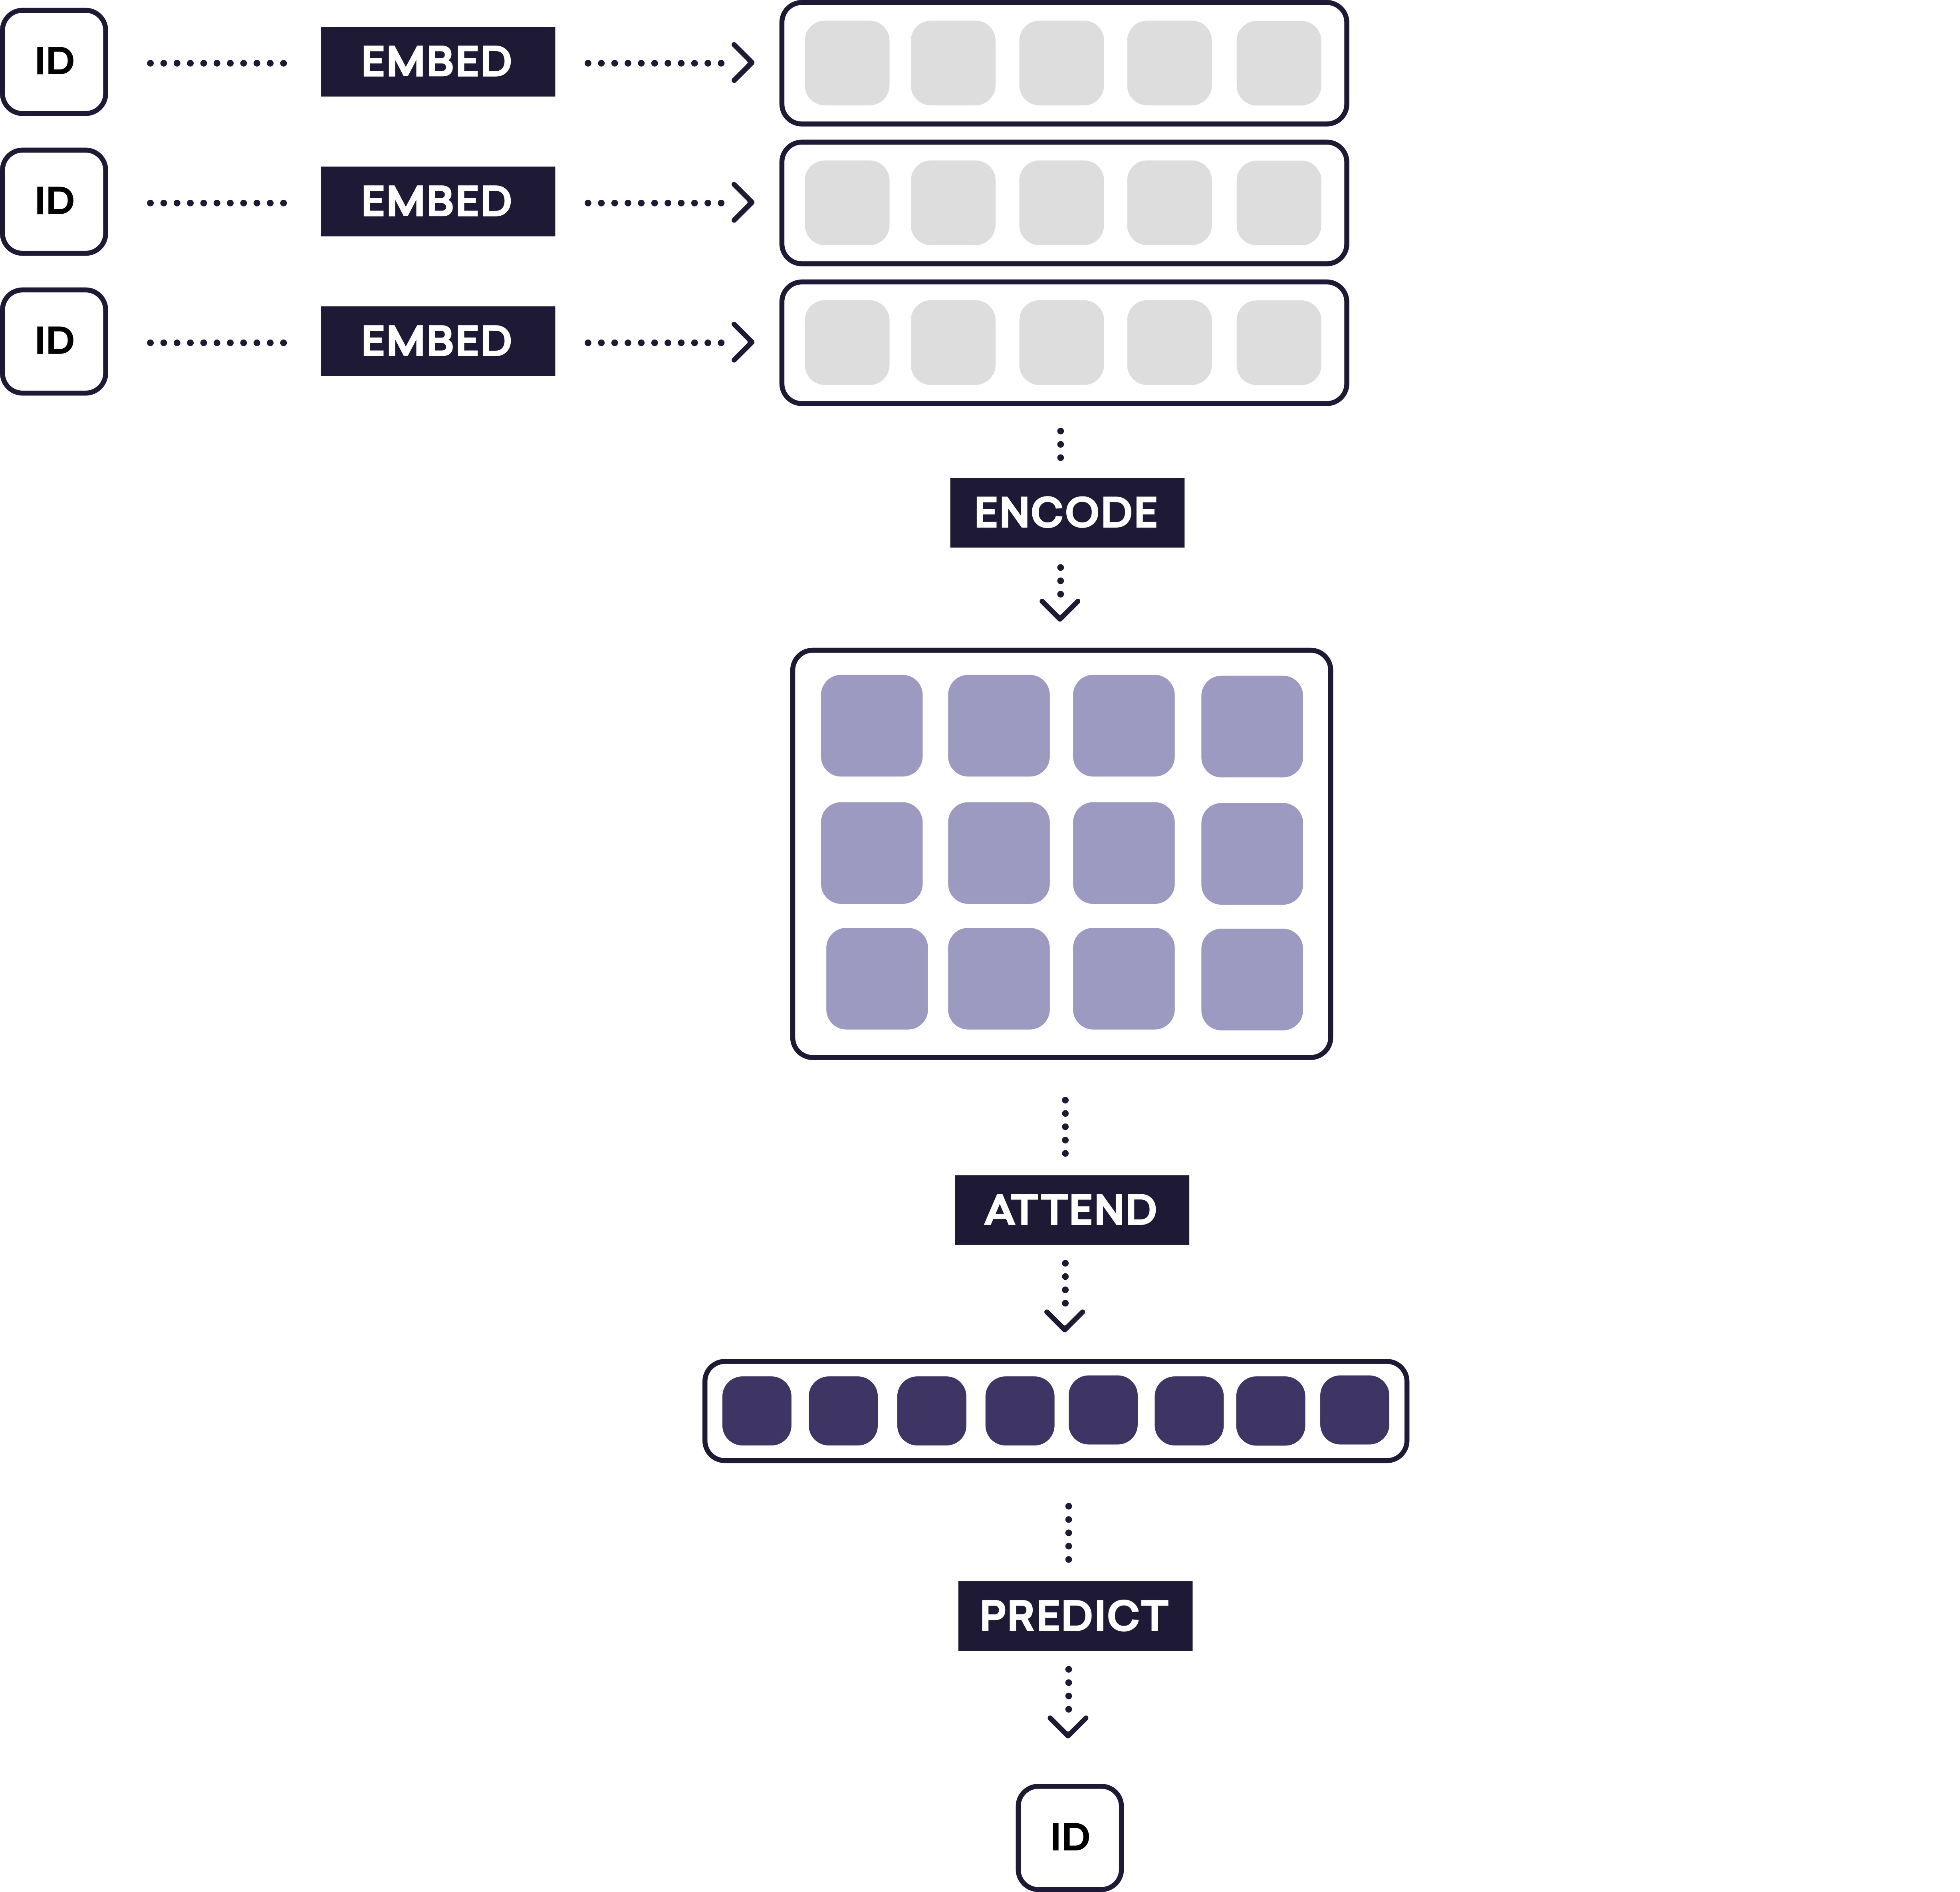

1. embed: rather than representing tokens as one-hot vectors, represent each token as a dense vector. Word embeddings have become a standard tool in both NLP and political science and adding them to NLP systems greatly improves their accuracy.
2. encode: once we've embedded our tokens, we want to encode them in a way incorporates their context in the sentence and their role in the downstream task. (E.g., "security" has a very different meaning if it's preceeded by "national" or "social"). One common way to encode tokens is using a recurrent neural network, which operates on a sequence of tokens in order. Models like GRUs (gated recurrent units) or LSTMs (long short-term memory) can create intermediate representations of a sentences that account for the words used on either side.
3. attend: many NLP tasks require reshaping data into a single vector to apply a model to it. For instance, a document that is represented as a sequence of tokens generally needs to be represented as a single, fixed-length vector if we're doing document classification. This step can be optional, but work in the past several years has shown the power of attention-based models (see below).
4. predict: once we have a good document or token representation, we can predict a token- or document label or, if we're doing something like machine translation, generate a token or character.

Recently, the dominant approach to this four step framework is a transformer model, such as BERT. Transformer models are built on "attention" mechanisms, which are beyond the scope of this tutorial but are explained well in many nice blogs, including, e.g. [[here](https://jalammar.github.io/visualizing-neural-machine-translation-mechanics-of-seq2seq-models-with-attention/)] and [[here](https://jalammar.github.io/illustrated-transformer/)]. A high-level way to think about attention models is that the model simultaneously learns two sub-models: how to represent a token, and how to weight that token's representation when using it for a downstream task.

spaCy's English `sm`, `md`, and `lg` models use a convolutional neural network. Words are *embedded* using either GLoVe or a subword feature embedding model, *encoded* with a CNN that stacks multiple convolutional layers to give each vector a receptive field that encompasses multiple words, and optionally uses *attention* for document classification.  Its English `trf` model uses a RoBERTa-based transformer. See [here](https://spacy.io/api/architectures#tok2vec-arch) for more details.


### Types of IE

There are many techniques for information extraction beyond named entity recognition. While they're beyond the scope of tutorial, we can briefly talk about each and what they're useful for.

- **named entity recognition**: we're covering this one in depth, but tl;dr: identify named entities such as people, locations, organizations, dates, and cardinals (numbers) as well as less common labels like "work of art" or or "law".
- **entity disambiguation/resolution/linking/lookup**: a common next step after named entity recognition is identifying which names refer to the same entity. For instance, an article could refer to "President Obama", "Barack Obama", "Obama", all of which refer to the same person. Linking or disambiguating these names can make them much more useful in answering applied questions.
- **relation extraction**: an extension to named entity recognition is to identify the *relations* between entities described in text. Some classic examples of relation extraction are BornIn(Person, Location) or EmployeeOf(Person, Organization), and the task becomes to identify which named entities have each relation type. While this is relatively uncommon in political science, it has a lot of promise for applications like constructing bipartite graphs from raw text data.
- **Open IE**: Open information extraction is similar to relation extraction except that it does not rely on a predefined ontology of relation types and instead returns subject/verb/object triples. For instance, given the following sentence [[link](https://github.com/knowitall/openie/])], an Open IE system could return several triplets:
  "The U.S. president Barack Obama gave his speech on Tuesday to thousands of people" -->
  - (Barack Obama, is the president of, the U.S.)
  - (Barack Obama, gave, his speech)
  - (Barack Obama, gave his speech, on Tuesday)
  - (Barack Obama, gave his speech, to thousands of people)
- **event extraction/frame semantic parsing**: event extraction is to process of identifying whether a given event type is described in text and to identify the words or phrases associated with each of its "arguments". For instance, an "ATTACK" event might have a roles or arguments for "perpetrator", "victim", and "weapon". Researchers in both NLP and political science have worked on event extraction systems for decades. In general, NLP systems tend to work on event types that are grounded in computational linguistics work about the range of actions or event types. Research in NLP has produced machine learning-based event extractors that are relatively accurate on the event types they were trained on. These event types do not always match the event types that political scientists are interested in. Event extractors in political science have largely been rule-based, using large hand-specified dictionaries, but are increasingly ML-based. [[more info]](https://andrewhalterman.com/publication/learning-events-from-text/)
- **question answering**: an increasingly common approach to information extraction is the "question answering" framework, where an automated system tries to identify the passage in a piece of text that provides the answer to a given question. What's especially exciting about this approach is that it can often be performed with off-the-shelf models that don't require any additional training at all. For instance, the number of protesters at a demonstration can be extracted fairly accurately with an off-the-shelf model that is given a news story about a protest and the question "How many people protested?" [[link](https://arxiv.org/abs/2105.11260)].


## Back to NER Applications

What kinds of questions can we answer with NER and how does this fit in with our research?

The simplest questions are simple descriptive question, especially questions that could be useful at the beginning of a research project or when a research would like to understand the contents of a corpus better.

One of the simplest questions that someone to ask is which  people, organizations, and locations are mentioned most?

- **Question**: How could this be useful in research?



As an example, let's identify which organization are mentioned most in our corpus.

At this point our documents should all be processed. Do a quick check that they are:


In [ ]:
len(docs)

7729

In [ ]:
## refresher on the spacy objects:

# list of docs --> doc --> spans and docs --> tokens
# ent.text
# [token for token in doc]

In [ ]:
from collections import Counter

all_orgs = []
for d in docs:
    orgs = [ent.text for ent in d.ents if ent.label_ == "ORG"]
    all_orgs.extend(orgs)

Counter(all_orgs).most_common(15)

[('the Syrian Arab Army', 3058),
 ('SAA', 1531),
 ('the Islamic State', 1393),
 ('the Turkish Armed Forces', 1353),
 ('the Syrian Army', 1226),
 ('The Syrian Arab Army', 1180),
 ('SDF', 1033),
 ('ISIS', 879),
 ('the Turkish Army', 824),
 ('Islamic State', 761),
 ('FSA', 744),
 ('Al-Mughair', 697),
 ('Handarat Refugee Camp', 697),
 ('Al-Quds Brigade', 697),
 ('Allahuakbar', 697)]

**Questions**

- What does this tell us substantively about the conflict?
- How could the results be more useful? /what's missing that would make them more insightful.

### Another NER example: ceasefires and organizations

A simple extention is to study which organizations are mentioned alongside certain keywords. In practice, this would probably involve looking at organizations alongside document classifications or topics, but we can use keywords as a rough approximation here.


**Exercise**: Which organizations are mentioned most alongside mentions of "ceasefires" or "negotiations"?

In [ ]:
# write code here

# Hint: ent.sent.text will return the text of the sentence where entity `ent` is mentioned



In [ ]:
#@title
negotiation_orgs = []
for d in docs:
    for ent in d.ents:
        if ent.label_ != "ORG":
            continue
        if re.search("negotiat|ceasefire|talks", ent.sent.text):
            negotiation_orgs.append(ent.text)

#Counter(negotiation_orgs).most_common(10)

#[('UN', 214),
# ('the United Nations Special', 159),
# ('United Nations', 107),
# ('the Syrian Opposition', 97),
# ('The Syrian Arab Army', 1),
# ('SAA', 1)]

# Caveat: what about "government"? Not an NE, so won't be there.

NameError: ignored

## Dependency parses

Named entity recognition is useful for identifying named entities in isolation or in the context of other terms or concepts. NER on its own tells us little about the relationships between named entities. Often, the relationship between entities is the interesting piece of information for applied researchers, and we can get at that relationship by using the grammar of the sentence.


Dependency parses are a way of representing the syntax or grammar of a sentence. For example, a dependency parse might identify that a particular verb is a noun, and specifically that it is the subject noun of a sentence.

While this isn't strictly speaking information extraction (although it is structured prediction), having access to a dependency parse can be very valuable in extracting information from documents.

First, let's look at how a dependency parse encodes grammatical information by using spaCy's dependency visualizer.

In [ ]:
doc = nlp(articles[313]['body'])
sent = list(doc.sents)[1]
displacy.render(sent, style="dep", jupyter=True)

You can think about dependency parses as a greatly enhanced form of part of speech tagging. While part of speech tagging assigns labels to individual words, like "Russian" being an ADJ[ective], "jets" being a NOUN, and "traveled" being a VERB (the labels below each word), dependency parsing goes a step further and tells you that the noun "jet" is specifically the subject noun ("nsubj") of the verb "traveled", and that "Russian" is not only an adjective, but specifically an adjective that is modifying the word "jets".

The implementation of dependency parsers is beyond the scope of this tutorial. Dependency parsing is a more complicated task than named entity recognition, given that a model needs to infer a tree structure that is subject to constraints (e.g. each word can only have a single "head" word immediately above it in the tree), and also needs to predict the correct label for each relationship. A useful list of different implementations is available at [Papers With Code](https://paperswithcode.com/task/dependency-parsing).

### Example information extraction with dependency parses

On its own, a dependency parse doesn't give you the ability to extract information from documents. That said, the information within a dependency parse can help you with a rule-based for extracting information.

One thing we might want to be able to extract from text is generally what kinds of behaviors or actions are occurring in a particular location. Let's write a function to identify verbs + direct objects that are grammatically linked to a location.

In [ ]:
print(doc)
tok = doc[21]  # "Aleppo"
print(tok)


def loc_to_verb(tok):
    verb_phrase = []
    # first, iterate through all the ancesters of the token
    for i in tok.ancestors:
        # when you get to a verb (using a POS tag)...
        if i.pos_ == "VERB":
            # ...add the verb to the verb phrase list
            verb_phrase.append(i)
            # then, also add the direct object(s) of the verb, as long as the original token
            # is in the same subtree as the direct object
            verb_phrase.extend([j for j in i.children if j.dep_ == "dobj" and tok in i.subtree])
            # we only want the first verb, so stop after we find one
            break
    # expand out the verb phrase to get modifiers ("amod") of the direct object
    for i in verb_phrase:
        for j in i.children:
            if j.dep_ == "amod":
                verb_phrase.append(j)

    # sort the tokens by their position in the original sentence
    new_list = sorted(verb_phrase, key=lambda x: x.i)
    # join them together with the correct whitespace and return
    return ''.join([i.text_with_ws for i in new_list]).strip()

loc_to_verb(tok)

BEIRUT, LEBANON (10:20 P.M.) – The Russian Air Force has launched several airstrikes over the eastern countryside of Aleppo tonight, hitting several of the Islamic State’s (ISIS) positions between Deir Hafer and Al-Bab.
Russian jets traveled from the Hmaymim Military Airport in southwest Latakia to the Aleppo Governorate tonight in order to aid the Syrian and Turkish armies currently battling with the Islamic State forces in the Al-Bab Plateau and Deir Hafer Plain.
According to local reports, Russian jets primarily focused on the  road leading from Al-Bab to Deir Hafer; this area is where the Syrian Arab Army is currently attacking the Islamic State forces.
Russian jets are still launching airstrikes this minute, forcing the Islamic State terrorists to to avoid launching counter-attacks against the Syrian and Turkish armies in east Aleppo.
Aleppo


'launched several airstrikes'

We can then use our function to identify all the actions related to a single city, Aleppo.

In [ ]:
aleppo_actions = []

for d in docs:
    for i in d:
        if i.text == "Aleppo":
            aleppo_actions.append(loc_to_verb(i))

sorted(list(set(aleppo_actions)))

['',
 'According',
 'added',
 'announced',
 'approached rebel position',
 'arrange new agreement',
 'await official reports',
 'beheaded youngster',
 'captured',
 'captured number',
 'captured villages',
 'carried fire',
 'carried strikes 3000Leramonmall',
 'conducted',
 'continued',
 'continued advance',
 'continued powerful assault',
 'continued\xa0assault',
 'damaging reputation',
 'defending rebel assault',
 'destroyed large depot',
 'distributed',
 'downed',
 'erupted',
 'fight way',
 'fighting',
 'fighting Syrian government',
 'finish study',
 'fired several rockets',
 'firing several rockets',
 'hit hospital',
 'holds Aleppo',
 'killed',
 'launched massive offensives',
 'launched several airstrikes',
 'launching airstrikes',
 'launching counter-attacks',
 'let assault',
 'located',
 'located km',
 'looked',
 'massacring civilians',
 'met garrison',
 'note',
 'operating',
 'positioned',
 'pounding main jihadist road',
 'poured',
 'rained held districts',
 'recaptured area',
 'red

### Proxy groups example

Researchers in political science are deeply interested in the relations between armed groups in complex civil wars such as the civil war in Syria [[link](https://www.saraplana.com/research.html)]. One important step in collecting data on proxy conflict is identifying which armed groups are backed by whom. This relationship is often reported in the press as, e.g "the US-backed SDF" or "Iranian-backed Hezbollah".

Here's an example function to identify who's backing whom using the common "backed" construction.



In [ ]:

def clean_phrase(subtree):
    """Sort and join tokens into a string"""
    new_list = sorted(list(subtree), key=lambda x: x.i)
    return ''.join([i.text_with_ws for i in new_list])


for i in doc:
    # Find instances of the word "backed" that play the role of an adjectival modifier
    if i.text == "backed" and i.dep_ == "amod":
        # The children of "backed" will report who the backer is
        print("Backer: ", clean_phrase(i.children))
        # Next, we go up one level to the immediate parent of the word "backed"
        parent = list(i.ancestors)[0]
        branches = [parent]
        # for each of the children of that word, except for the original "backed" token,
        # add it to the branch
        for j in parent.children:
            if j != i:
                branches.append(j)

        print(branches)



## Exercise: who's attacking whom?

We saw in our earlier Aleppo example that many of the events occurring in Aleppo involves military attacks, for example, "launching counter-attacks" or "resumed assault". A researcher might want to know who's attacking and who is being attacked, either to help understand the contours of the conflict or to generate quantitative data on the military course of the conflict.

Spend some time writing a function to identify who's attacking whom in the corpus.

Hints:

- you can use the `lemma_` attribute on a spaCy token to get its lemma form, so, for example, taking the lemma of "attack", "attacked", and "attacking" will all be "attack".
- think the role of subject nouns, direct objects, and prepositional phrases.
- the `spacy.explain()` function can help explain labels (e.g. `spacy.explain("amod") --> "adjectival modifier"`


In [ ]:
# look for attack events between entities

## Summary: Extracting Information with Rules and Dependency Parses

What we've done is an example of rule-based information extraction using dependency parses as a component in our rule-based system. An alternative approach to rule-based extraction is to train a machine learning model to extract the information you're looking for. Machine learning models are often more accurate and less sensitive to small changes in language than rule-based systems are. Rule-based systems have their place, though. Researchers do not need to annotate large amounts of data to create rule-based systems, and it's easier to understand why a system returned the answer it did than is often the case with machine learning systems.



# Extentions and Experiments

### Transformer-based spaCy model

How does the accuracy change if you use the model with pretrained embeddings (`en_core_web_lg`) or the transformer-based model (`en_core_web_trf`)? (If you use the transformer model, you'll probably want to change your runtime to GPU, which will require you to re-install the libraries you installed at the beginning of the notebook).

In [ ]:
!python -m spacy download en_core_web_trf

nlp_trf = spacy.load("en_core_web_trf")

doc = nlp_trf(articles[313]['body'])
displacy.render(doc, style="ent", jupyter=True)

     |████████████████████████████████| 460.2 MB 7.6 kB/s 
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_trf')


### Question-Answering

As we discussed briefly above, the "question-answering" framework can be very effective for extracting information, especially in a zero-shot situation where we have no additional training data.

One popular QA training dataset is SQuAD2, and we can download a transformer model that's already been trained on SQuAD from the Huggingface model repository.

In [ ]:
display(sent.text)

'\nRussian jets traveled from the Hmaymim Military Airport in southwest Latakia to the Aleppo Governorate tonight in order to aid the Syrian and Turkish armies currently battling with the Islamic State forces in the Al-Bab Plateau and Deir Hafer Plain.'

In [ ]:
from transformers import AutoModelForQuestionAnswering, AutoTokenizer, pipeline

model_name = "deepset/roberta-base-squad2"

hugg = pipeline('question-answering', model=model_name, tokenizer=model_name)

Downloading:   0%|          | 0.00/571 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/496M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/79.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/899k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/456k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/772 [00:00<?, ?B/s]

In [ ]:
QA_input = {
    'question': "Who controls Deir Hafer and Al-Bab?",
    'context': sent.text
}
res = hugg(QA_input)

print(res)

{'score': 0.3062118589878082, 'start': 186, 'end': 199, 'answer': 'Islamic State'}


**Questions**

- What kinds of tasks can you frame in terms of question answering?
- Why might you not want to use a QA approach?
- What happens if you give the model a different question? What about a nonsensical question?

## Extensions

There's lots of room to mix-and-match different methods:

- How are people or organizations correlated with the topics from a topic model like LDA?
- how to the embeddings for person phrases change over time?
- Can we classify documents like political speeches using only specific parts of speech, like adjectives or verbs? Can we measure rhetorical style by quantifying the grammatical structure of a document?
- Can we improve the generalizability of a document classifier or topic model by removing proper names before training?


